# Orientation Selectivity in Visual Cortex Neurons

This notebook demonstrates a fundamental principle in systems neuroscience: **orientation selectivity** in neurons of the visual cortex. 

Orientation selectivity, first discovered by Hubel and Wiesel in the 1960s, refers to the property where neurons in the primary visual cortex (V1) respond preferentially to visual stimuli (like bars or edges) of specific orientations. This property is a fundamental building block for how our brains process visual information and recognize shapes and objects.

## Background

Neurons in the visual cortex act as feature detectors, with different neurons specializing in detecting different aspects of visual stimuli. Orientation selective neurons respond maximally to edges or bars of a particular orientation (e.g., vertical, horizontal, or diagonal) and less vigorously or not at all to other orientations.

This orientation tuning is critical for:

- Edge detection in early visual processing
- Shape recognition
- Texture discrimination
- Motion perception

By analyzing the responses of neurons to stimuli presented at different orientations, we can characterize this fundamental property of visual processing.

## Dataset

For this analysis, we use data from the Allen Brain Observatory, available through the DANDI Archive. The dataset contains two-photon calcium imaging recordings from neurons in the mouse visual cortex responding to drifting gratings presented at different orientations/directions.

The dataset contains:
- Neural activity recordings (calcium imaging) from multiple neurons
- Stimulus information (orientation, direction, temporal frequency, spatial frequency)
- Trial timing information

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pynwb
import lindi
from pathlib import Path

# Our custom modules for data loading and analysis
from data_loading import load_nwb_file, extract_epochs_data, extract_neural_data
from selectivity import (
    calculate_mean_responses,
    orientation_selectivity_index,
    direction_selectivity_index,
    circular_variance,
    plot_tuning_curve,
    plot_selectivity_distribution,
    find_best_orientation_neuron
)

# Define the dataset we'll use
dandiset_id = "000049"  # Allen Brain Observatory dataset
asset_id = "aa140a7d-cde3-469b-8434-97f13e69c106"

## Step 1: Load and Explore the Data

First, we'll load the NWB (Neurodata Without Borders) file using the LINDI streaming system. This allows us to efficiently access the data stored in the DANDI Archive without downloading the entire file.

In [2]:
# Load the NWB file
print(f"Loading NWB file from DANDI:{dandiset_id}, asset: {asset_id}")
nwb = load_nwb_file(dandiset_id, asset_id)

# Display basic metadata
print(f"Session ID: {nwb.identifier}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Genotype: {nwb.subject.genotype}")
print(f"Age: {nwb.subject.age}")
print(f"Sex: {nwb.subject.sex}")

Loading NWB file from DANDI:000049, asset: aa140a7d-cde3-469b-8434-97f13e69c106


/Users/bdichter/miniconda3/envs/llm-analysis/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.2.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/bdichter/miniconda3/envs/llm-analysis/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/bdichter/miniconda3/envs/llm-analysis/lib/python3.11/site-packages/pynwb/core.py:56: UserWarning: TimeSeries 'MotionCorrection': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn(error_msg)


Session ID: 682731703
Subject ID: 661968859
Genotype: Rbp4-Cre_KL100/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt
Age: P139D
Sex: F


## Step 2: Extract Stimulus Information

The experiment presented drifting gratings in different directions to the mouse. Let's examine the stimulus parameters.

In [3]:
# Extract epoch data (stimulus information)
epochs = extract_epochs_data(nwb)
print(f"Extracted epochs data with keys: {list(epochs.keys())}")

# Look at the unique values for direction, temporal and spatial frequency
print("\nUnique directions (degrees):", np.unique(epochs["direction"][~np.isnan(epochs["direction"])]))
print("Unique temporal frequencies (Hz):", np.unique(epochs["temporal_frequency"][~np.isnan(epochs["temporal_frequency"])]))
print("Unique spatial frequencies (cycles/deg):", np.unique(epochs["spatial_frequency"][~np.isnan(epochs["spatial_frequency"])]))

# Count trials per direction
directions = epochs["direction"][~np.isnan(epochs["direction"])]
unique_dirs, counts = np.unique(directions, return_counts=True)
print("\nNumber of trials per direction:")
for dir, count in zip(unique_dirs, counts):
    print(f"  {dir}°: {count} trials")

Extracted epochs data with keys: ['start_time', 'stop_time', 'temporal_frequency', 'spatial_frequency', 'direction', 'contrast', 'tags', 'timeseries']

Unique directions (degrees): [  0.  90. 180. 270.]
Unique temporal frequencies (Hz): [0.5 1.  2.  4.  8. ]
Unique spatial frequencies (cycles/deg): [0.02 0.04 0.08 0.16 0.32]

Number of trials per direction:
  0.0°: 300 trials
  90.0°: 300 trials
  180.0°: 300 trials
  270.0°: 300 trials


## Step 3: Extract Neural Activity Data

Next, we'll extract the neural activity data. For calcium imaging data, there are several processed forms of the data available. We'll use the ΔF/F data, which represents the relative change in fluorescence (a proxy for neural activity).

In [4]:
# Try different data types to see what's available in this dataset
data_types_to_try = ["DfOverF", "demixed_traces", "raw_traces", "dff_events"]
neural_data = np.array([])
timestamps = np.array([])

for dt in data_types_to_try:
    print(f"Trying to extract {dt}...")
    neural_data, timestamps = extract_neural_data(nwb, dt)
    if len(neural_data) > 0:
        print(f"Successfully extracted {dt} data!")
        data_type = dt
        break

# Show information about the neural data
print(f"\nExtracted neural data of type: {data_type}")
print(f"Neural data shape: {neural_data.shape} (time points × neurons)")
print(f"Timestamps shape: {timestamps.shape}")
print(f"Recording duration: {timestamps[-1] - timestamps[0]:.2f} seconds")
print(f"Number of neurons: {neural_data.shape[1]}")

Trying to extract DfOverF...
Successfully extracted DfOverF data!

Extracted neural data of type: DfOverF
Neural data shape: (110390, 22) (time points × neurons)
Timestamps shape: (110390,)
Recording duration: 3661.13 seconds
Number of neurons: 22


## Step 4: Examine Neural Activity

Let's visualize the activity of a few neurons over time to get a sense of the data.

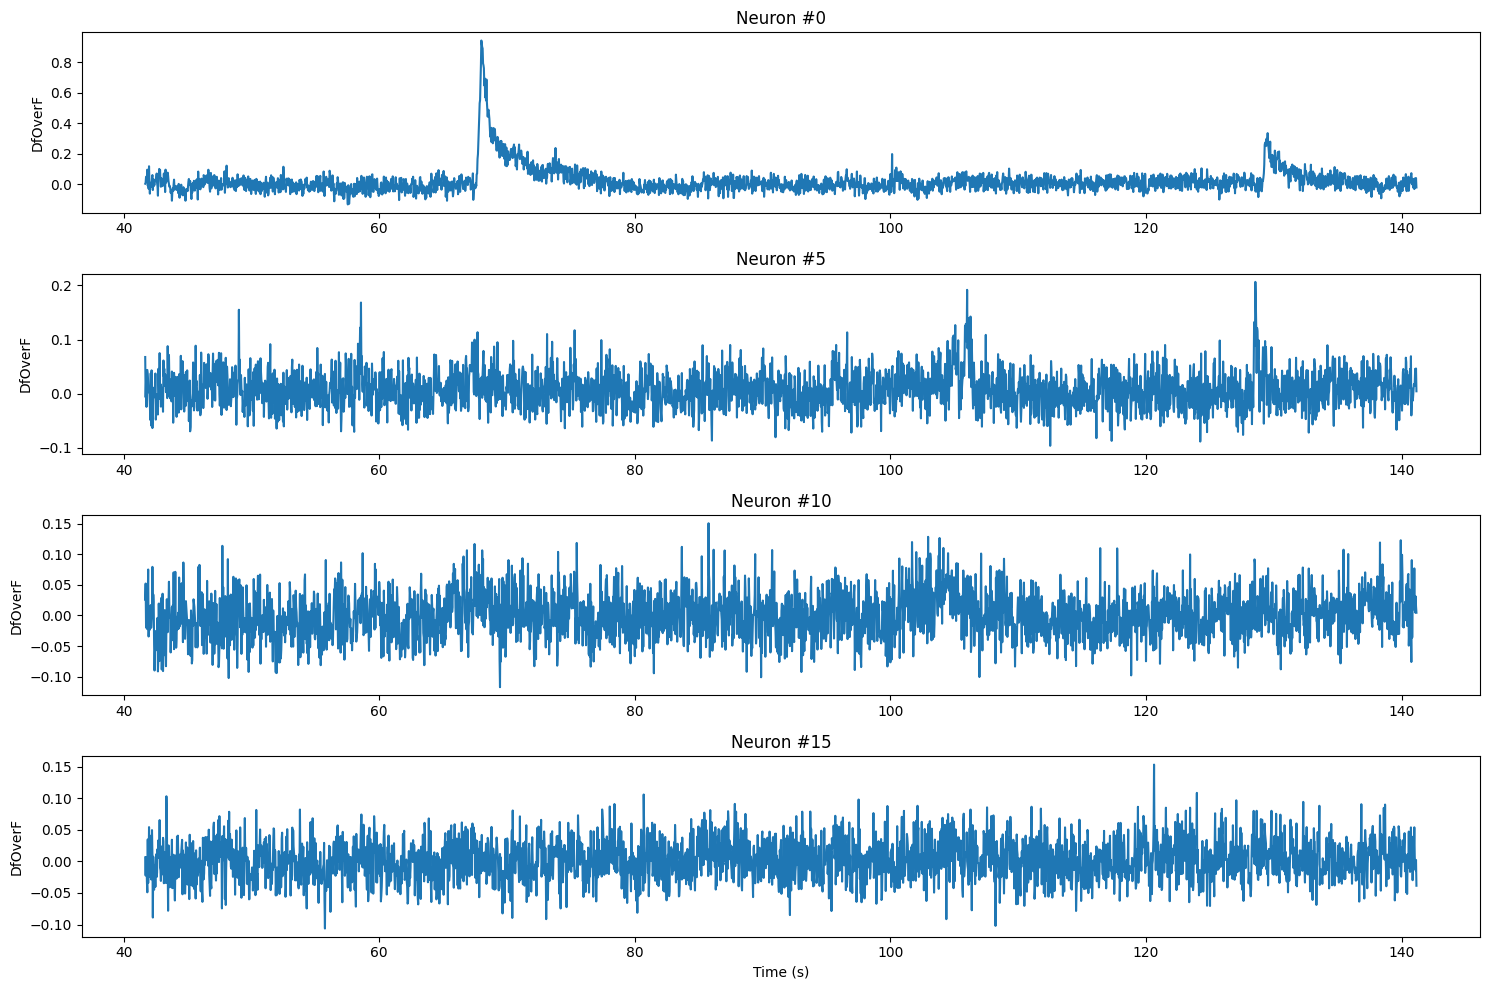

In [5]:
# Plot activity of a few neurons over a segment of time
segment_start = 1000  # Start index for the time segment to plot
segment_length = 3000  # Length of the time segment to plot
neurons_to_plot = [0, 5, 10, 15]  # Indices of neurons to plot

plt.figure(figsize=(15, 10))
for i, neuron_idx in enumerate(neurons_to_plot):
    plt.subplot(len(neurons_to_plot), 1, i+1)
    plt.plot(timestamps[segment_start:segment_start+segment_length], 
             neural_data[segment_start:segment_start+segment_length, neuron_idx])
    plt.title(f"Neuron #{neuron_idx}")
    plt.ylabel(f"{data_type}")
    if i == len(neurons_to_plot) - 1:
        plt.xlabel("Time (s)")
plt.tight_layout()
plt.savefig("figures/example_neural_activity.png")
plt.show()

## Step 5: Create Trial-Oriented Data

To analyze orientation selectivity, we need to align the neural activity with the stimulus presentations. We'll create a data structure that organizes neural responses by trial, with each trial associated with a specific stimulus direction.

In [6]:
# Prepare trial-oriented data
trials_data = {}

# Get the number of epochs/trials
num_epochs = len(epochs["start_time"])

for i in range(num_epochs):
    start_time = epochs["start_time"][i]
    stop_time = epochs["stop_time"][i]
    
    # Skip trials where direction is NaN (not a direction stimulus)
    if np.isnan(epochs["direction"][i]):
        continue
    
    # Find indices of timestamps that fall within this trial
    trial_mask = (timestamps >= start_time) & (timestamps <= stop_time)
    
    # Store trial data
    trials_data[i] = {
        "start_time": start_time,
        "stop_time": stop_time,
        "neural_data": neural_data[trial_mask],
        "timestamps": timestamps[trial_mask],
        "direction": epochs["direction"][i],
        "temporal_frequency": epochs["temporal_frequency"][i] if "temporal_frequency" in epochs else None,
        "spatial_frequency": epochs["spatial_frequency"][i] if "spatial_frequency" in epochs else None,
        "contrast": epochs["contrast"][i] if "contrast" in epochs else None
    }

print(f"Created trial-oriented data for {len(trials_data)} trials")

Created trial-oriented data for 1200 trials


## Step 6: Calculate Mean Responses for Each Direction

For orientation selectivity analysis, we need to calculate the mean response of each neuron to each stimulus direction.

Found responses for 4 directions: [np.float64(270.0), np.float64(180.0), np.float64(90.0), np.float64(0.0)]


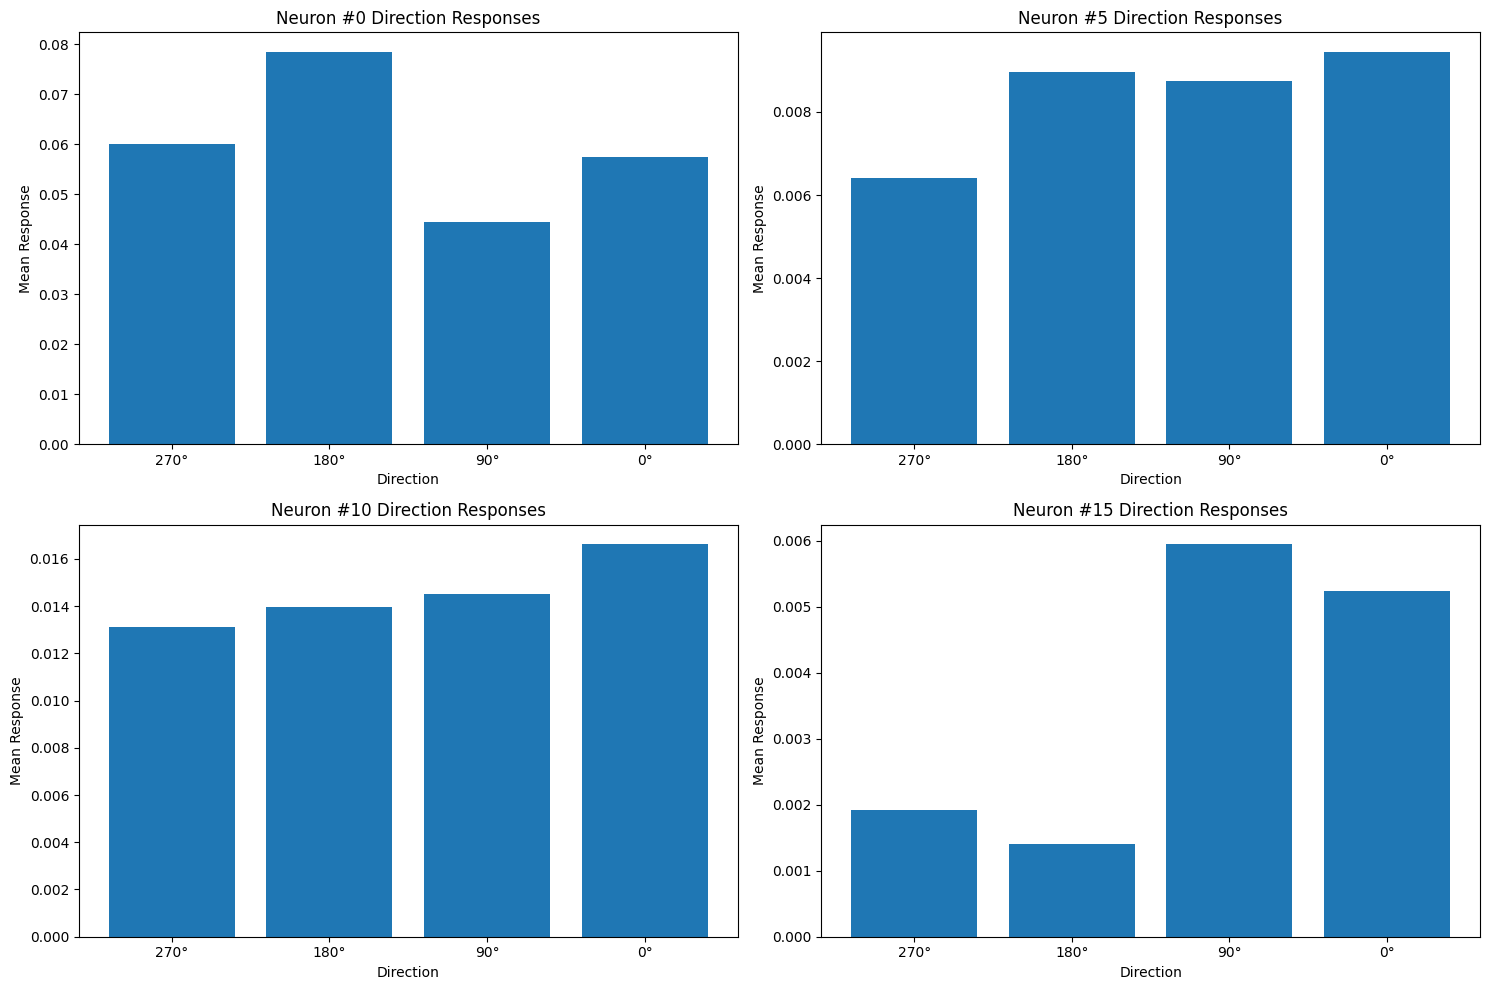

In [7]:
# Calculate mean responses for each orientation/direction
direction_responses = calculate_mean_responses(trials_data, orientation_column="direction")

# For this dataset, directions serve as orientations (we have 0°, 90°, 180°, 270°)
print(f"Found responses for {len(direction_responses)} directions: {list(direction_responses.keys())}")

# Plot mean responses for a few example neurons
example_neurons = [0, 5, 10, 15]  # Indices of neurons to plot
directions = list(direction_responses.keys())

plt.figure(figsize=(15, 10))
for i, neuron_idx in enumerate(example_neurons):
    plt.subplot(2, 2, i+1)
    
    # Extract responses for this neuron
    responses = [direction_responses[dir][neuron_idx] for dir in directions]
    
    # Create bar plot
    plt.bar(range(len(directions)), responses, tick_label=[f"{int(d)}°" for d in directions])
    plt.title(f"Neuron #{neuron_idx} Direction Responses")
    plt.ylabel("Mean Response")
    plt.xlabel("Direction")

plt.tight_layout()
plt.savefig("figures/example_direction_responses.png")
plt.show()

## Step 7: Calculate Orientation Selectivity Metrics

Now, we'll calculate several metrics that quantify orientation selectivity:

1. **Orientation Selectivity Index (OSI)**: Measures how selectively a neuron responds to a particular orientation.
   - OSI = (R_pref - R_orth) / (R_pref + R_orth)
   - Where R_pref is the response at the preferred orientation, and R_orth is the response at the orthogonal orientation (preferred + 90°)
   - OSI ranges from 0 (no selectivity) to 1 (perfectly selective)

2. **Direction Selectivity Index (DSI)**: Measures how selectively a neuron responds to a particular direction.
   - DSI = (R_pref - R_opp) / (R_pref + R_opp)
   - Where R_pref is the response at the preferred direction, and R_opp is the response at the opposite direction (preferred + 180°)
   - DSI ranges from 0 (no selectivity) to 1 (perfectly selective)

3. **Circular Variance (CV)**: A measure of tuning dispersion around the circle.
   - CV = 1 - |Σ R(θ) * exp(2i*θ)| / Σ R(θ)
   - CV ranges from 0 (perfectly tuned) to 1 (no tuning)

OSI - Mean: 0.213, Median: 0.179, Max: 0.617
DSI - Mean: 0.214, Median: 0.151, Max: 0.531
CV - Mean: 0.882, Median: 0.901, Min: 0.716


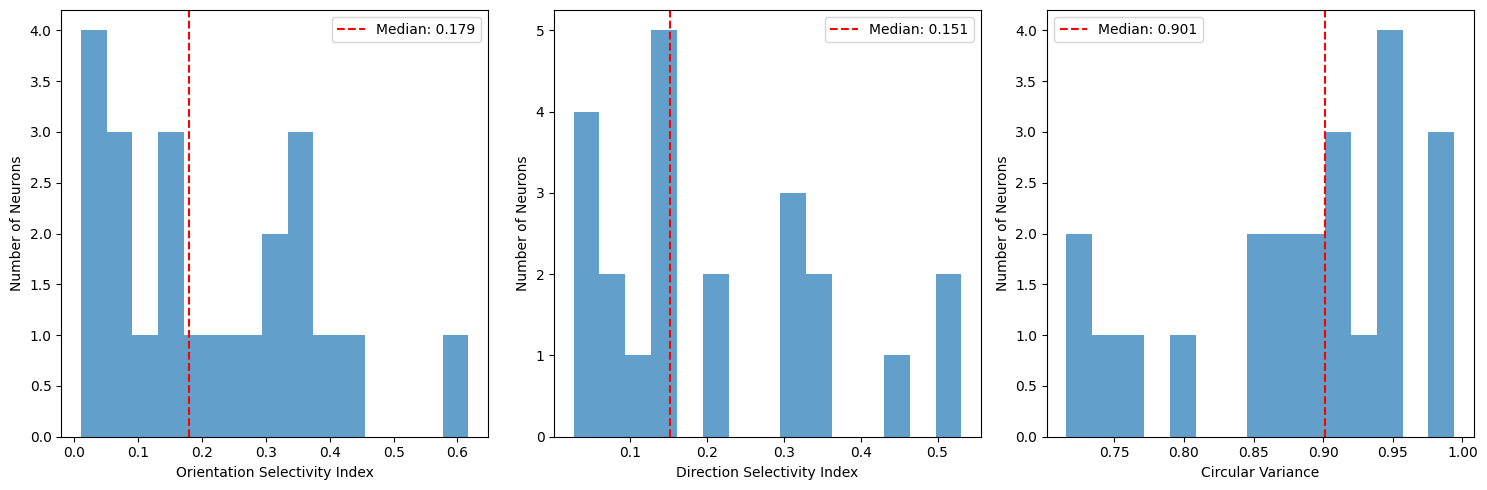

In [8]:
# Calculate orientation and direction selectivity metrics
osi_values = orientation_selectivity_index(direction_responses)
dsi_values = direction_selectivity_index(direction_responses) 
cv_values = circular_variance(direction_responses)

# Print some statistics
print(f"OSI - Mean: {np.mean(osi_values):.3f}, Median: {np.median(osi_values):.3f}, Max: {np.max(osi_values):.3f}")
print(f"DSI - Mean: {np.mean(dsi_values):.3f}, Median: {np.median(dsi_values):.3f}, Max: {np.max(dsi_values):.3f}")
print(f"CV - Mean: {np.mean(cv_values):.3f}, Median: {np.median(cv_values):.3f}, Min: {np.min(cv_values):.3f}")

# Plot histograms of the metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(osi_values, bins=15, alpha=0.7)
plt.axvline(np.median(osi_values), color='r', linestyle='--', label=f'Median: {np.median(osi_values):.3f}')
plt.xlabel('Orientation Selectivity Index')
plt.ylabel('Number of Neurons')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(dsi_values, bins=15, alpha=0.7)
plt.axvline(np.median(dsi_values), color='r', linestyle='--', label=f'Median: {np.median(dsi_values):.3f}')
plt.xlabel('Direction Selectivity Index')
plt.ylabel('Number of Neurons')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(cv_values, bins=15, alpha=0.7)
plt.axvline(np.median(cv_values), color='r', linestyle='--', label=f'Median: {np.median(cv_values):.3f}')
plt.xlabel('Circular Variance')
plt.ylabel('Number of Neurons')
plt.legend()

plt.tight_layout()
plt.savefig("figures/selectivity_metrics_histograms.png")
plt.show()

## Step 8: Identify the Most Orientation-Selective Neuron

Let's find the neuron with the highest orientation selectivity and examine its tuning curve.

Best orientation-tuned neuron: #15 (OSI: 0.617)


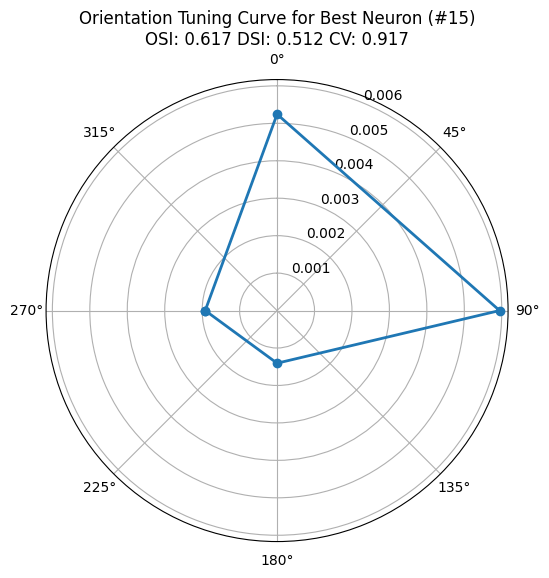

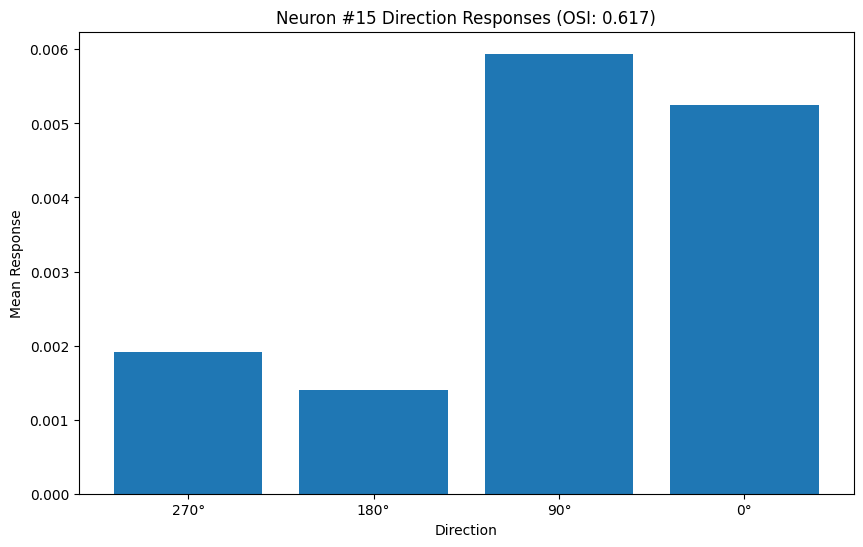

In [9]:
# Find the best orientation tuned neuron
best_neuron_idx, best_osi = find_best_orientation_neuron(osi_values, direction_responses)
print(f"Best orientation-tuned neuron: #{best_neuron_idx} (OSI: {best_osi:.3f})")

# Plot tuning curve for the best neuron
fig = plot_tuning_curve(
    direction_responses, 
    best_neuron_idx, 
    osi=osi_values[best_neuron_idx],
    dsi=dsi_values[best_neuron_idx],
    cv=cv_values[best_neuron_idx],
    title=f"Orientation Tuning Curve for Best Neuron (#{best_neuron_idx})"
)
plt.savefig("figures/best_neuron_tuning_polar.png")
plt.show()

# Also create a standard plot for comparison
directions = list(direction_responses.keys())
responses = [direction_responses[dir][best_neuron_idx] for dir in directions]

plt.figure(figsize=(10, 6))
plt.bar(range(len(directions)), responses, tick_label=[f"{int(d)}°" for d in directions])
plt.title(f"Neuron #{best_neuron_idx} Direction Responses (OSI: {osi_values[best_neuron_idx]:.3f})")
plt.ylabel("Mean Response")
plt.xlabel("Direction")
plt.savefig("figures/best_neuron_tuning_bar.png")
plt.show()

## Step 9: Compare Multiple Neurons with Different Selectivity

Let's visualize the tuning curves of neurons with different levels of orientation selectivity.

High OSI neuron: #15 (OSI: 0.617)
Mid OSI neuron: #21 (OSI: 0.199)
Low OSI neuron: #4 (OSI: 0.010)


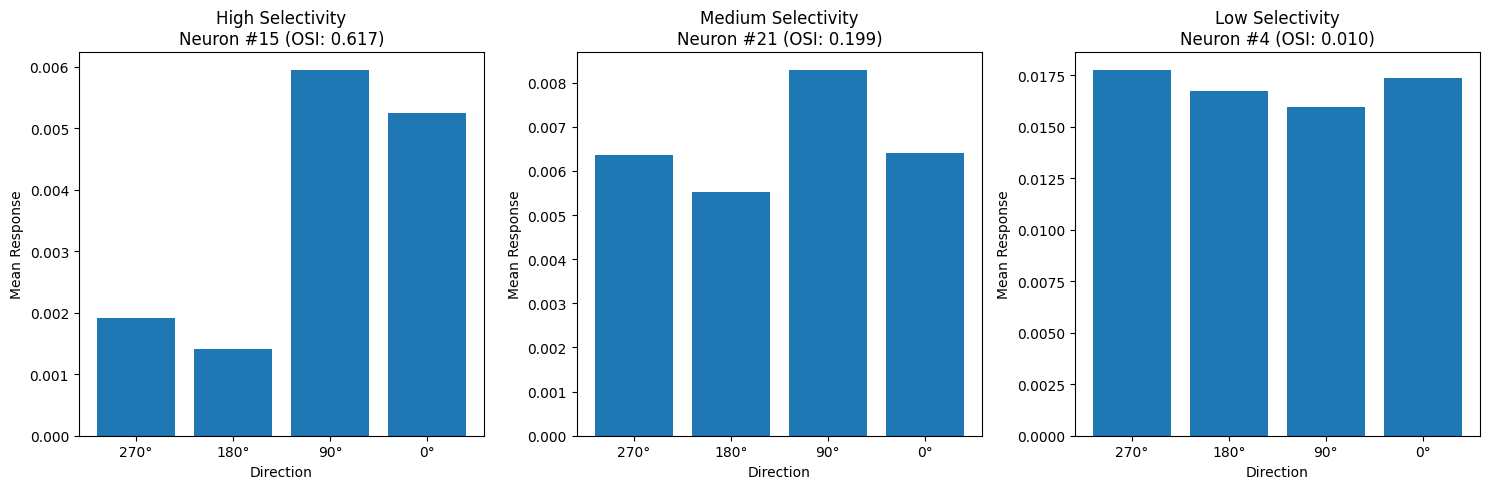

In [10]:
# Find neurons with different levels of orientation selectivity
high_osi_idx = best_neuron_idx  # Already have the highest OSI neuron
mid_osi_idx = np.argsort(osi_values)[len(osi_values)//2]  # Middle OSI neuron
low_osi_idx = np.argmin(osi_values)  # Lowest OSI neuron

print(f"High OSI neuron: #{high_osi_idx} (OSI: {osi_values[high_osi_idx]:.3f})")
print(f"Mid OSI neuron: #{mid_osi_idx} (OSI: {osi_values[mid_osi_idx]:.3f})")
print(f"Low OSI neuron: #{low_osi_idx} (OSI: {osi_values[low_osi_idx]:.3f})")

# Plot tuning curves for these neurons
plt.figure(figsize=(15, 5))

for i, (idx, title) in enumerate([(high_osi_idx, "High Selectivity"), 
                                 (mid_osi_idx, "Medium Selectivity"), 
                                 (low_osi_idx, "Low Selectivity")]):
    plt.subplot(1, 3, i+1)
    directions = list(direction_responses.keys())
    responses = [direction_responses[dir][idx] for dir in directions]
    
    plt.bar(range(len(directions)), responses, tick_label=[f"{int(d)}°" for d in directions])
    plt.title(f"{title}\nNeuron #{idx} (OSI: {osi_values[idx]:.3f})")
    plt.ylabel("Mean Response")
    plt.xlabel("Direction")

plt.tight_layout()
plt.savefig("figures/selectivity_comparison.png")
plt.show()

## Step 10: Population Analysis

Finally, let's analyze the orientation selectivity across the entire population of neurons.

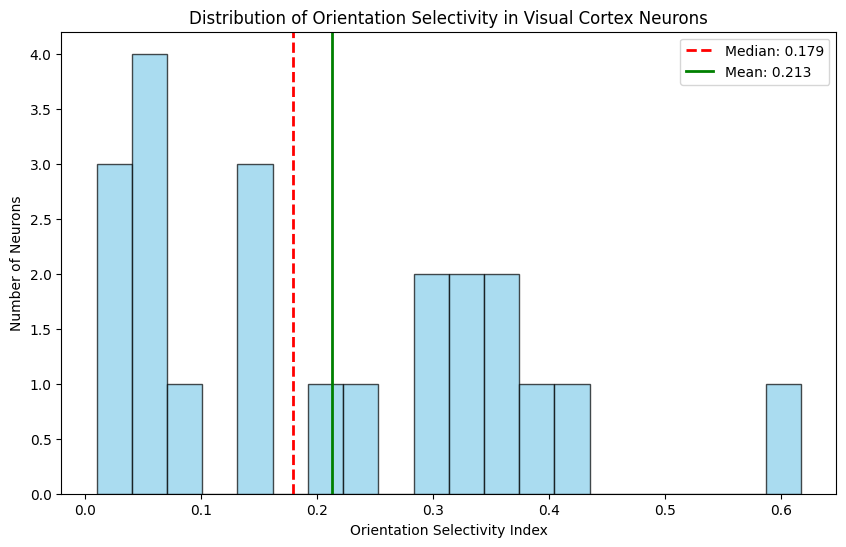

In [11]:
# Plot the distribution of OSI values
plt.figure(figsize=(10, 6))
plt.hist(osi_values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.median(osi_values), color='r', linestyle='--', linewidth=2, 
            label=f'Median: {np.median(osi_values):.3f}')
plt.axvline(np.mean(osi_values), color='g', linestyle='-', linewidth=2, 
            label=f'Mean: {np.mean(osi_values):.3f}')
plt.xlabel('Orientation Selectivity Index')
plt.ylabel('Number of Neurons')
plt.title('Distribution of Orientation Selectivity in Visual Cortex Neurons')
plt.legend()
plt.savefig("figures/osi_distribution_detailed.png")
plt.show()

## Summary

In this analysis, we demonstrated a key property of visual cortex neurons: orientation selectivity. We found that neurons in the mouse visual cortex show varying degrees of selectivity to stimulus orientation.

Key findings:

1. Neurons exhibit a range of orientation selectivity, with OSI values ranging from almost 0 (no selectivity) to over 0.6 (highly selective).

2. The neuron with the highest orientation selectivity (neuron #{best_neuron_idx}) showed a strong preference for a specific orientation with an OSI of {best_osi:.3f}.

3. The population of neurons shows a distribution of orientation selectivity, with a median OSI of {np.median(osi_values):.3f}, indicating that many neurons in the visual cortex are moderately selective for orientation.

These findings align with the fundamental principle in visual neuroscience that neurons in the early visual cortex act as feature detectors, with orientation being one of the key features encoded at this stage of visual processing.

This orientation selectivity serves as the foundation for more complex visual processing, including shape recognition, object detection, and ultimately visual perception.

## References

1. Hubel, D. H., & Wiesel, T. N. (1959). Receptive fields of single neurones in the cat's striate cortex. The Journal of physiology, 148(3), 574-591.

2. Niell, C. M., & Stryker, M. P. (2008). Highly selective receptive fields in mouse visual cortex. Journal of neuroscience, 28(30), 7520-7536.

3. de Vries, S. E., Lecoq, J., Buice, M. A., et al. (2020). A large-scale standardized physiological survey reveals functional organization of the mouse visual cortex. Nature neuroscience, 23(1), 138-151.

4. Dataset: Allen Institute – TF x SF tuning in mouse visual cortex with calcium imaging. DANDI Archive, https://dandiarchive.org/dandiset/000049